# Peptides encoding (One-hot)

In [1]:
import peptides
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from math import sqrt

# libs for ml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
#from umap import UMAP

# my module with some func
import pepcode

## Set parameters: 

In [2]:
AA_LIST = pepcode.AA_LIST

latent_dims = 200
num_epochs = 500 
batch_size = 1000
learning_rate = 1e-3 
use_gpu = True

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### Loading datasets

In [3]:
data = pd.read_csv('./dataset/vdjdb-2024-11-27-fixed/vdjdb.slim.txt', sep = '\t')
data = data[(data.gene == 'TRB') & (data.species == 'HomoSapiens')]
data.reset_index(drop=True, inplace=True)
index_list = []
for i in range(len(data)):
    if len(data.iloc[i].cdr3)==15 and data.iloc[i].cdr3[0]=='C' and (data.iloc[i].cdr3[-1]=='F' or data.iloc[i].cdr3[-1]=='W'):
        continue
    else:
        index_list.append(i)
data.drop(index=index_list, inplace=True)
data.reset_index(drop=True, inplace=True)
# data.sample(frac=1, random_state=100).reset_index(drop=True, inplace=True)
data = shuffle(data)

#Split dataset and prepare train, test, evaluation datasets
train_size, test_size, eval_size = int(round(len(data)*0.7, 0)), int(round(len(data)*(0.7+0.15), 0)), int(round(len(data)*(1), 0))
data_split = np.split(data, [train_size, test_size, eval_size], axis=0)
data_train = data_split[0]
data_test = data_split[1]
data_eval = data_split[2]

# Prepare peptide lists
pep_train_list = data_train.cdr3.values
pep_test_list = data_test.cdr3.values
pep_eval_list = data_eval.cdr3.values

len_seq = len(pep_train_list[0])


pep_train_oh = np.zeros((len(pep_train_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_train_oh)):
    pep_train_oh[i] = pepcode.one_hot_code(pep_train_list[i])

pep_test_oh = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_test_list)):
    pep_test_oh[i] = pepcode.one_hot_code(pep_test_list[i])   


oh_matr_size = pep_test_oh[0].size

# Пока не нужно
pep_eval_oh = np.zeros((len(pep_eval_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_eval_list)):
    pep_eval_oh[i] = pepcode.one_hot_code(pep_eval_list[i])  

# Prepare train dataloader
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_train_oh), torch.tensor(np.ones(pep_train_oh.shape[0])))
oh_dl_train = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=False)

# Prepare test dataloader
oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_test_oh), torch.tensor(np.ones(pep_test_oh.shape[0])))
oh_dl_test= torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=False)

# Evaluation (пока не нужно)
oh_dataset_eval = torch.utils.data.TensorDataset(torch.tensor(pep_eval_oh), torch.tensor(np.ones(pep_eval_oh.shape[0])))
oh_eval_dl = torch.utils.data.DataLoader(oh_dataset_eval, batch_size=batch_size, shuffle=False)


/Users/alex/miniconda3/envs/tcreppred_sil2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Autoencoder_1 definition (300->150)

In [4]:
numb = 1
autoencoder_arch = '300->150 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=150)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=150, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 90450


### Train autoencoder

In [5]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

torch.save(autoencoder_1, f'One-hot_models/model{numb}.pth')

Training ...
Epoch [1 / 500] average reconstruction error: 0.233255
Epoch [11 / 500] average reconstruction error: 0.027996
Epoch [21 / 500] average reconstruction error: 0.024371
Epoch [31 / 500] average reconstruction error: 0.019644
Epoch [41 / 500] average reconstruction error: 0.016297
Epoch [51 / 500] average reconstruction error: 0.013875
Epoch [61 / 500] average reconstruction error: 0.011810
Epoch [71 / 500] average reconstruction error: 0.010150
Epoch [81 / 500] average reconstruction error: 0.008802
Epoch [91 / 500] average reconstruction error: 0.007536
Epoch [101 / 500] average reconstruction error: 0.006315
Epoch [111 / 500] average reconstruction error: 0.005292
Epoch [121 / 500] average reconstruction error: 0.004538
Epoch [131 / 500] average reconstruction error: 0.003988
Epoch [141 / 500] average reconstruction error: 0.003545
Epoch [151 / 500] average reconstruction error: 0.003161
Epoch [161 / 500] average reconstruction error: 0.002825
Epoch [171 / 500] average rec

### Evaluation

In [6]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.000169


### Biological evaluatiuon

In [7]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

pep_test_list_bef_ae_aa = []
pep_test_list_aft_ae_aa = []
for i in range(len(pep_test_list_bef_ae)):
    for j in pep_test_list_bef_ae[i]:
        pep_test_list_bef_ae_aa.append(j)
    for k in pep_test_list_aft_ae[i]:
        pep_test_list_aft_ae_aa.append(k)

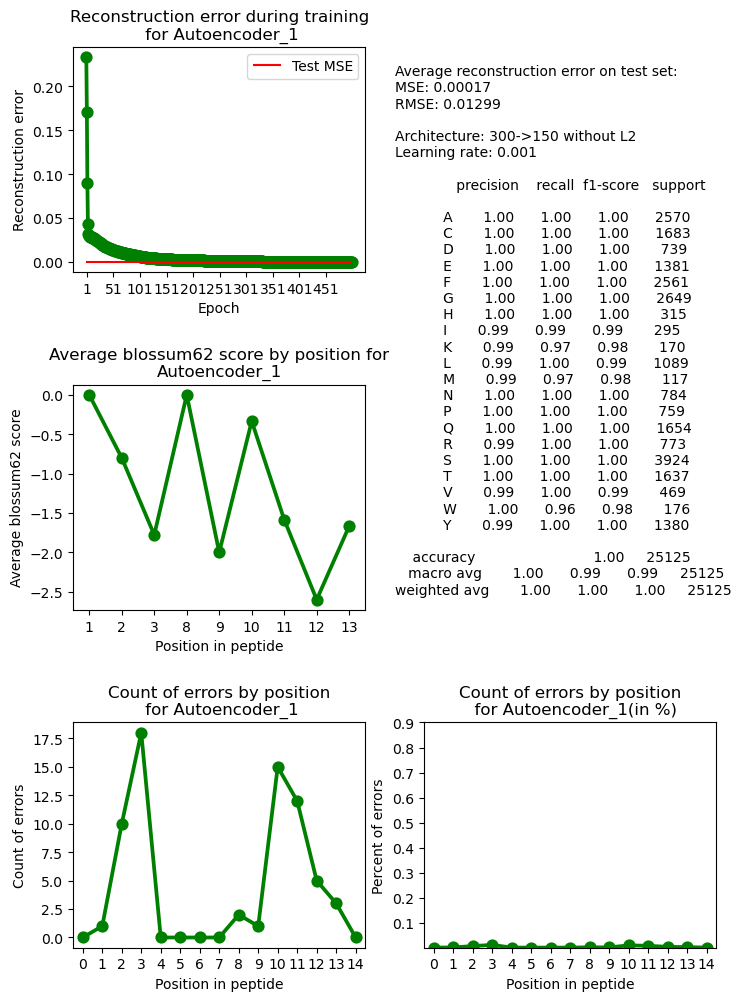

In [8]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

sns.pointplot(train_loss_avg_1 , color = 'green', ax=axs[0, 0])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[1,0])
sns.pointplot(err_count, color = 'green', ax=axs[2, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[2, 1])
axs[0, 0].hlines(round(test_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Test MSE')
axs[0, 0].legend()
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}\n\n{classification_report(pep_test_list_bef_ae_aa, pep_test_list_aft_ae_aa)}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
axs[1, 1].set(frame_on=False)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')

## Autoencoder_2 definition (300->200)

In [9]:
numb += 1
autoencoder_arch = '300->200 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_2 = Autoencoder()

autoencoder_2 = autoencoder_2.to(device)

num_params = sum(p.numel() for p in autoencoder_2.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_2.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 120500


### Train autoencoder

In [10]:
# set to training mode
autoencoder_2.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_2(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

torch.save(autoencoder_2, f'One-hot_models/model{numb}.pth')

Training ...
Epoch [1 / 500] average reconstruction error: 0.231954
Epoch [11 / 500] average reconstruction error: 0.027384
Epoch [21 / 500] average reconstruction error: 0.022612
Epoch [31 / 500] average reconstruction error: 0.017475
Epoch [41 / 500] average reconstruction error: 0.014267
Epoch [51 / 500] average reconstruction error: 0.011720
Epoch [61 / 500] average reconstruction error: 0.009725
Epoch [71 / 500] average reconstruction error: 0.008117
Epoch [81 / 500] average reconstruction error: 0.006629
Epoch [91 / 500] average reconstruction error: 0.005372
Epoch [101 / 500] average reconstruction error: 0.004469
Epoch [111 / 500] average reconstruction error: 0.003837
Epoch [121 / 500] average reconstruction error: 0.003334
Epoch [131 / 500] average reconstruction error: 0.002888
Epoch [141 / 500] average reconstruction error: 0.002537
Epoch [151 / 500] average reconstruction error: 0.002297
Epoch [161 / 500] average reconstruction error: 0.002086
Epoch [171 / 500] average rec

### Evaluation

In [11]:
autoencoder_2.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_2(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.000139


### Biological evaluatiuon

In [12]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

pep_test_list_bef_ae_aa = []
pep_test_list_aft_ae_aa = []
for i in range(len(pep_test_list_bef_ae)):
    for j in pep_test_list_bef_ae[i]:
        pep_test_list_bef_ae_aa.append(j)
    for k in pep_test_list_aft_ae[i]:
        pep_test_list_aft_ae_aa.append(k)

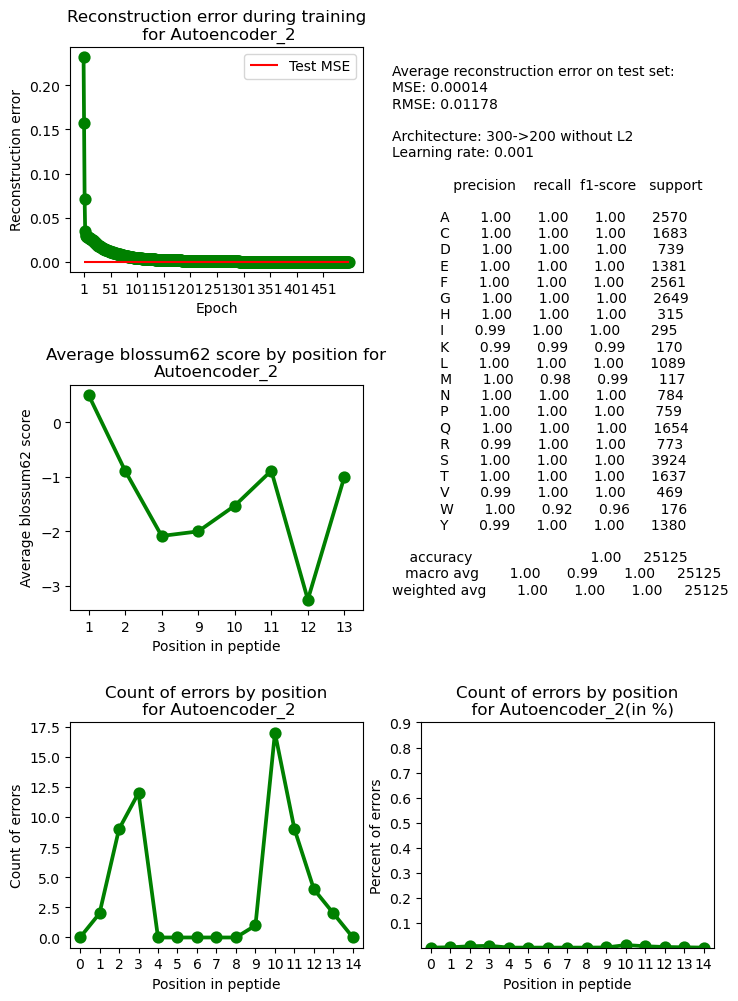

In [13]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

sns.pointplot(train_loss_avg_1 , color = 'green', ax=axs[0, 0])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[1,0])
sns.pointplot(err_count, color = 'green', ax=axs[2, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[2, 1])
axs[0, 0].hlines(round(test_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Test MSE')
axs[0, 0].legend()
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}\n\n{classification_report(pep_test_list_bef_ae_aa, pep_test_list_aft_ae_aa)}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
axs[1, 1].set(frame_on=False)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')

## Autoencoder_3 definition (300->250)

In [14]:
numb += 1
autoencoder_arch = '300->250 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=250)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=250, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_3 = Autoencoder()

autoencoder_3 = autoencoder_3.to(device)

num_params = sum(p.numel() for p in autoencoder_3.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_3.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 150550


### Train autoencoder

In [15]:
# set to training mode
autoencoder_3.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_3(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

torch.save(autoencoder_3, f'One-hot_models/model{numb}.pth')

Training ...
Epoch [1 / 500] average reconstruction error: 0.223531
Epoch [11 / 500] average reconstruction error: 0.026836
Epoch [21 / 500] average reconstruction error: 0.021161
Epoch [31 / 500] average reconstruction error: 0.016269
Epoch [41 / 500] average reconstruction error: 0.013146
Epoch [51 / 500] average reconstruction error: 0.010501
Epoch [61 / 500] average reconstruction error: 0.008542
Epoch [71 / 500] average reconstruction error: 0.006891
Epoch [81 / 500] average reconstruction error: 0.005481
Epoch [91 / 500] average reconstruction error: 0.004439
Epoch [101 / 500] average reconstruction error: 0.003700
Epoch [111 / 500] average reconstruction error: 0.003146
Epoch [121 / 500] average reconstruction error: 0.002707
Epoch [131 / 500] average reconstruction error: 0.002350
Epoch [141 / 500] average reconstruction error: 0.002082
Epoch [151 / 500] average reconstruction error: 0.001861
Epoch [161 / 500] average reconstruction error: 0.001637
Epoch [171 / 500] average rec

### Evaluation

In [16]:
autoencoder_3.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_3(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.000109


### Biological evaluatiuon

In [17]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

pep_test_list_bef_ae_aa = []
pep_test_list_aft_ae_aa = []
for i in range(len(pep_test_list_bef_ae)):
    for j in pep_test_list_bef_ae[i]:
        pep_test_list_bef_ae_aa.append(j)
    for k in pep_test_list_aft_ae[i]:
        pep_test_list_aft_ae_aa.append(k)

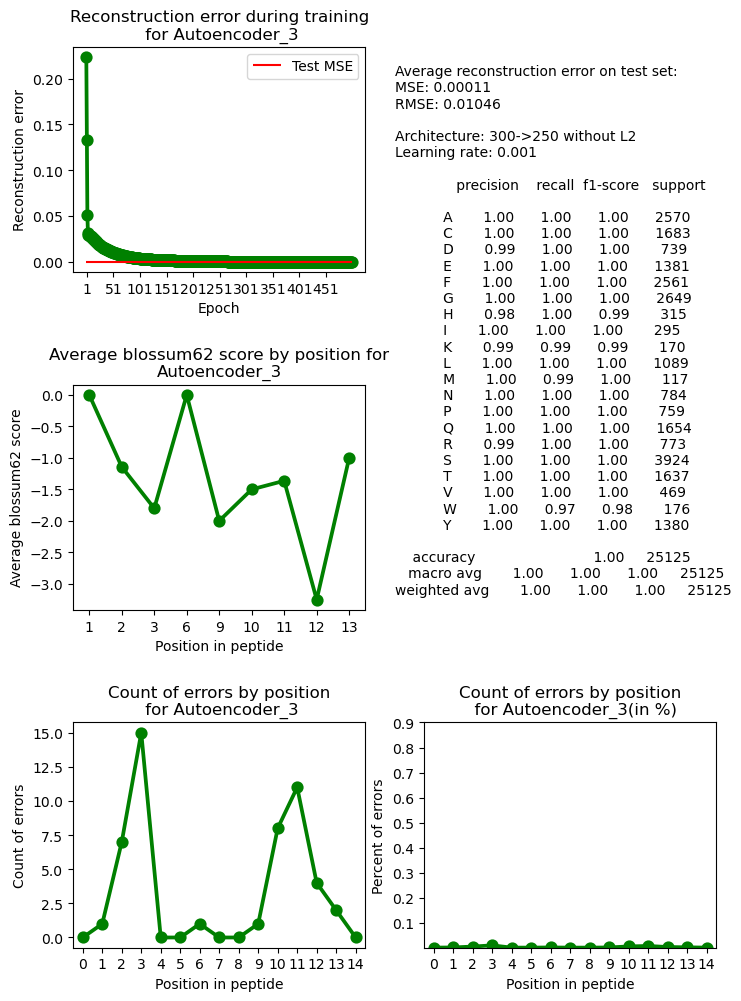

In [18]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

sns.pointplot(train_loss_avg_1 , color = 'green', ax=axs[0, 0])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[1,0])
sns.pointplot(err_count, color = 'green', ax=axs[2, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[2, 1])
axs[0, 0].hlines(round(test_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Test MSE')
axs[0, 0].legend()
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}\n\n{classification_report(pep_test_list_bef_ae_aa, pep_test_list_aft_ae_aa)}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
axs[1, 1].set(frame_on=False)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')

## Autoencoder_4 definition (300->300)

In [19]:
numb += 1
autoencoder_arch = '300->300 without L2'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=300)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=300, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_4 = Autoencoder()

autoencoder_4 = autoencoder_4.to(device)

num_params = sum(p.numel() for p in autoencoder_4.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_4.parameters(), lr = learning_rate)

Number of parameters for One-hot encoding: 180600


### Train autoencoder

In [20]:
# set to training mode
autoencoder_4.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_4(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

torch.save(autoencoder_4, f'One-hot_models/model{numb}.pth')

Training ...
Epoch [1 / 500] average reconstruction error: 0.222465
Epoch [11 / 500] average reconstruction error: 0.026311
Epoch [21 / 500] average reconstruction error: 0.019992
Epoch [31 / 500] average reconstruction error: 0.015308
Epoch [41 / 500] average reconstruction error: 0.011990
Epoch [51 / 500] average reconstruction error: 0.009320
Epoch [61 / 500] average reconstruction error: 0.007230
Epoch [71 / 500] average reconstruction error: 0.005498
Epoch [81 / 500] average reconstruction error: 0.004285
Epoch [91 / 500] average reconstruction error: 0.003477
Epoch [101 / 500] average reconstruction error: 0.002945
Epoch [111 / 500] average reconstruction error: 0.002563
Epoch [121 / 500] average reconstruction error: 0.002206
Epoch [131 / 500] average reconstruction error: 0.001945
Epoch [141 / 500] average reconstruction error: 0.001734
Epoch [151 / 500] average reconstruction error: 0.001523
Epoch [161 / 500] average reconstruction error: 0.001332
Epoch [171 / 500] average rec

### Evaluation

In [21]:
autoencoder_4.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_4(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.000093


### Biological evaluatiuon

In [22]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

pep_test_list_bef_ae_aa = []
pep_test_list_aft_ae_aa = []
for i in range(len(pep_test_list_bef_ae)):
    for j in pep_test_list_bef_ae[i]:
        pep_test_list_bef_ae_aa.append(j)
    for k in pep_test_list_aft_ae[i]:
        pep_test_list_aft_ae_aa.append(k)

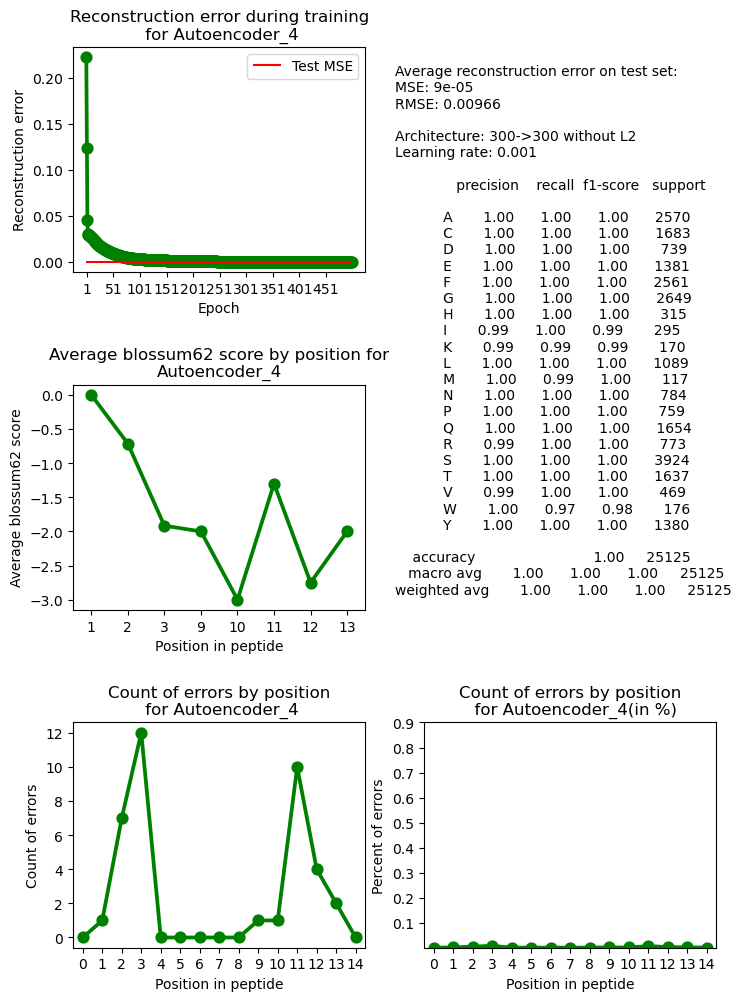

In [23]:
fig, axs = plt.subplots(3,2, figsize = [8.3, 11.7])

sns.pointplot(train_loss_avg_1 , color = 'green', ax=axs[0, 0])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[1,0])
sns.pointplot(err_count, color = 'green', ax=axs[2, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[2, 1])
axs[0, 0].hlines(round(test_loss_avg_1, 5), 0, num_epochs, color = 'red', label='Test MSE')
axs[0, 0].legend()
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = f'Reconstruction error during training\n for Autoencoder_{numb}', xticks=[i for i in range(1, num_epochs, int(num_epochs/10))])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=-0.1, y=-1.5, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\n\nArchitecture: {autoencoder_arch}\nLearning rate: {learning_rate}\n\n{classification_report(pep_test_list_bef_ae_aa, pep_test_list_aft_ae_aa)}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
axs[1, 1].set(frame_on=False)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autoencoder_{numb}')
axs[2, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autoencoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
fig.savefig(f'./Results_one_hot/{str(date.today())}_{numb}_{autoencoder_arch}.pdf', format='pdf')

## Model load

In [ ]:
model = torch.load('./One-hot_models/model2.pth', weights_only=False) # Class should be defined 

In [ ]:
data = pd.read_csv('./dataset/vdjdb-2024-11-27-fixed/vdjdb.slim.txt', sep = '\t')
data = data[(data.gene == 'TRB') & (data.species == 'HomoSapiens')]
data.reset_index(drop=True, inplace=True)
index_list = []
for i in range(len(data)):
    if len(data.iloc[i].cdr3)==15 and data.iloc[i].cdr3[0]=='C' and (data.iloc[i].cdr3[-1]=='F' or data.iloc[i].cdr3[-1]=='W'):
        continue
    else:
        index_list.append(i)
data.drop(index=index_list, inplace=True)
data.reset_index(drop=True, inplace=True)
data.sample(frac=1).reset_index(drop=True, inplace=True)
data_test = data.head(int(round(len(data)*0.15, 0))+1)
pep_list = data_test.cdr3.values

pep_oh = np.zeros((len(pep_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_list)):
    pep_oh[i] = pepcode.one_hot_code(pep_list[i])

oh_dataset = torch.utils.data.TensorDataset(torch.tensor(pep_oh), torch.tensor(np.ones(pep_oh.shape[0])))
oh_dl = torch.utils.data.DataLoader(oh_dataset, batch_size=batch_size, shuffle=False)
data_test

In [ ]:
model.eval()
output = []
num_batches = 0

# Прогоняем тестовую выборку через энкодер
for (pep, _) in oh_dl:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = model.encoder(pep)
        num_batches += 1
    output.append((pep, pep_recon))

output


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), 200), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, : ] = output[i][1].reshape((cur_batch_size, 200)).numpy(force=True)
    pointer += cur_batch_size

## Biological sense (Тут не нужно)

In [ ]:
fig, axs = plt.subplots(4,2, figsize = [8.3, 11.7])
perplexity_list = [0.1, 1, 5, 10, 20, 50, 100, 1000]

for i in range(len(perplexity_list)):
    tnse = TSNE(n_components=2, n_jobs=-1,
                n_iter=500, perplexity=perplexity_list[i])
    data_tnse = tnse.fit_transform(pep_test_oh_aft)
    sns.scatterplot(x=data_tnse [:, 0],
                    y=data_tnse [:, 1],
                    hue = data_test['antigen.species'].values.reshape(-1),
                    palette="colorblind", ax=axs[int(i%(len(perplexity_list)/2)), int(i//(len(perplexity_list)/2))])
    axs[int(i%(len(perplexity_list)/2)), int(i//(len(perplexity_list)/2))].set(xlabel='TSNE_1', ylabel='TSNE_2', title=f'TSNE for encoded peptides\nwith perplexity={perplexity_list[i]}')
    axs[int(i%(len(perplexity_list)/2)), int(i//(len(perplexity_list)/2))].legend().set_visible(False)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
pep_test_oh_bef_reshaped = pep_test_oh_bef.reshape(len(pep_test_list), len(pepcode.AA_LIST)*len_seq)

tnse = TSNE(n_components=2, n_jobs=-1,
                    n_iter=250, perplexity=150)
data_tnse = tnse.fit_transform(pep_test_oh_bef_reshaped)
sns.scatterplot(x=data_tnse [:, 0],
                y=data_tnse [:, 1],
                hue = data_test['j.segm'].values.reshape(-1),
                palette="colorblind")
plt.title('TSNE for encoded peptides')
plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.show()

In [ ]:
tnse = TSNE(n_components=2, n_jobs=-1,
                    n_iter=500, perplexity=500)
data_tnse = tnse.fit_transform(pep_test_oh_aft)
sns.scatterplot(x=data_tnse [:, 0],
                y=data_tnse [:, 1],
                hue = data_test['j.segm'].values.reshape(-1),
                palette="colorblind")
plt.title('TSNE for encoded peptides')
plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.show()

In [ ]:
fig, axs = plt.subplots(4,2, figsize = [8.3, 11.7])
perplexity_list = [0.1, 1, 5, 10, 20, 50, 100, 1000]

for i in range(len(perplexity_list)):
    tnse = TSNE(n_components=2, n_jobs=-1,
                n_iter=500, perplexity=perplexity_list[i])
    data_tnse = tnse.fit_transform(pep_test_oh_aft)
    sns.scatterplot(x=data_tnse [:, 0],
                    y=data_tnse [:, 1],
                    hue = data_test['antigen.epitope'].values.reshape(-1),
                    palette="colorblind", ax=axs[int(i%(len(perplexity_list)/2)), int(i//(len(perplexity_list)/2))])
    axs[int(i%(len(perplexity_list)/2)), int(i//(len(perplexity_list)/2))].set(xlabel='TSNE_1', ylabel='TSNE_2', title=f'TSNE for encoded peptides\nwith perplexity={perplexity_list[i]}')
    axs[int(i%(len(perplexity_list)/2)), int(i//(len(perplexity_list)/2))].legend().set_visible(False)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()